In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn
from sklearn.metrics import f1_score

In [3]:
df = pd.read_csv("train.csv")

## 모델 1) 클래스 1의 정확도와 재현율을 모두 고려한 경우


Confusion Matrix:
[[870 165]
 [133 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1035
           1       0.59      0.64      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409

Accuracy: 0.79


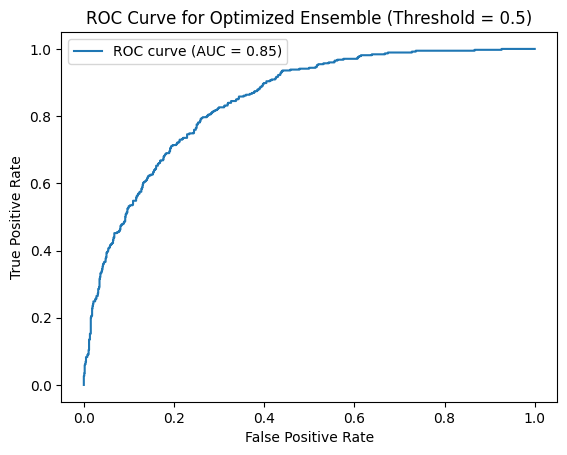

In [4]:
X = df.drop(columns=['Churn', 'customerID'], errors='ignore')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression 모델 정의
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

# Gradient Boosting 정의
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# XGBoost 모델 정의
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=1,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42
)

# 앙상블 모델 (Logistic Regression + Gradient Boosting + XGBoost) 정의 - 가중치 조정
ensemble_model = VotingClassifier(
    estimators=[('lr', lr_model), ('gb', gb_model), ('xgb', xgb_model)],
    voting='soft',
    weights=[2, 1, 2]  # Logistic Regression과 XGBoost에 더 많은 가중치 부여
)

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

# 테스트 데이터로 예측 확률 계산 및 임곗값 조정
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_threshold = (y_pred_prob_ensemble >= threshold).astype(int)

# 성능 평가
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_threshold))

accuracy = accuracy_score(y_test, y_pred_threshold)
print(f"Accuracy: {accuracy:.2f}")

# ROC-AUC 및 ROC Curve 출력
auc_score_ensemble = roc_auc_score(y_test, y_pred_prob_ensemble)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_prob_ensemble)

plt.plot(fpr_ensemble, tpr_ensemble, label=f"ROC curve (AUC = {auc_score_ensemble:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Ensemble (Threshold = 0.5)')
plt.legend()
plt.show()

## 모델2) 클래스 1(이탈 고객)의 정확도를 우선시 하는 경우


Confusion Matrix:
[[951  84]
 [190 184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.49      0.57       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.72      1409
weighted avg       0.79      0.81      0.79      1409

Accuracy: 0.81


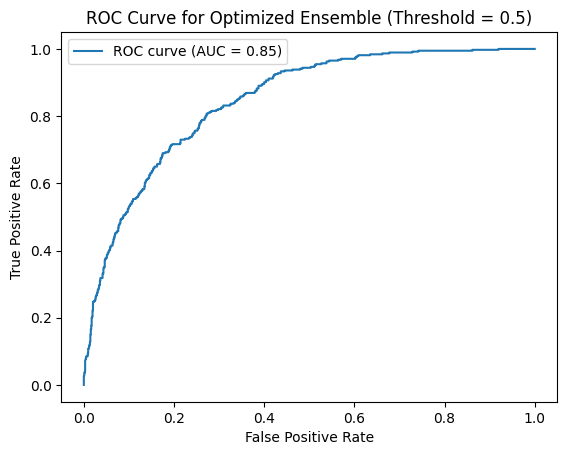

In [5]:
X = df.drop(columns=['Churn', 'customerID'], errors='ignore')
y = df['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Logistic Regression 모델 정의
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

# Gradient Boosting 및 최적화된 XGBoost 모델 정의
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=1,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42
)

# 앙상블 모델 (Logistic Regression + Gradient Boosting + XGBoost) 정의 - 가중치 조정
ensemble_model = VotingClassifier(
    estimators=[('lr', lr_model), ('gb', gb_model), ('xgb', xgb_model)],
    voting='soft',
    weights=[2, 1, 2] 
)

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

# 테스트 데이터로 예측 확률 계산 및 임곗값 조정
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
threshold = 0.6
y_pred_threshold = (y_pred_prob_ensemble >= threshold).astype(int)

# 성능 평가
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_threshold))

accuracy = accuracy_score(y_test, y_pred_threshold)
print(f"Accuracy: {accuracy:.2f}")

# ROC-AUC 및 ROC Curve 출력
auc_score_ensemble = roc_auc_score(y_test, y_pred_prob_ensemble)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_prob_ensemble)

plt.plot(fpr_ensemble, tpr_ensemble, label=f"ROC curve (AUC = {auc_score_ensemble:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Ensemble (Threshold = 0.5)')
plt.legend()
plt.show()